# Анализ сайта "СберАвтоподписка"

In [1]:
import pandas as pd
import pickle
import missingno as msno
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import optuna

## Load and Explore

### GA Sessions  Dataframe

In [3]:
with open('data/ga_sessions.pkl', 'rb') as file:
    df_ses = pickle.load(file)
print(f"Размер датафрейма: Колонок - {df_ses.shape[1]}, Строк - {df_ses.shape[0]}")
df_ses

Размер датафрейма: Колонок - 18, Строк - 1860042


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,None,NaN,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk


#### Общая информация о датафрейсе

In [4]:
df_ses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


#### Пропущенные значений

Матрица пропущенных значений

<AxesSubplot:>

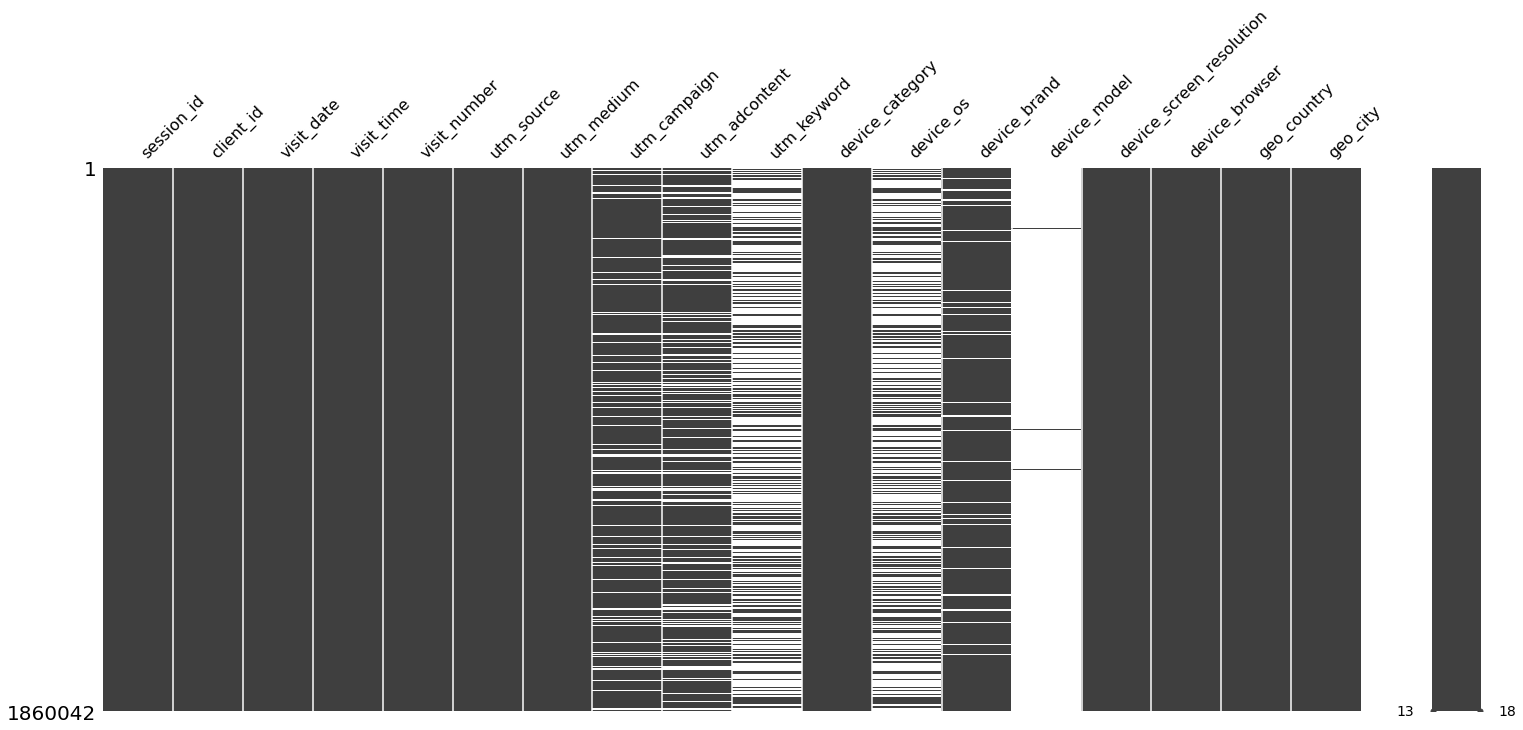

In [5]:
msno.matrix(df_ses)

Процент пропущенных значений по столбцам

In [6]:
missing_values = (df_ses.isna().sum() / len(df_ses) * 100).sort_values(ascending=False)
print("Процент пропущенных значений")
missing_values

Процент пропущенных значений


device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
utm_adcontent               18.043410
utm_campaign                11.806346
device_brand                 6.380394
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64

Выводы:
- столбец (device_model) - полностью неинформативен
- столбцы (utm_keyword, device_os) - больше чем наполовину пусты
- столбцы (utm_adcontent, utm_campaign) - имеют значительные пропуски
- столбцы (device_brand, utm_source) - имеют незначительные пропуски
- остальные столбцы пропусков не имеют

На этапе очистке данных (device_model) - можно будет удалить, остальные столбцы рассмотреть более детально

#### Дубликаты

In [7]:
df_ses[df_ses.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city


Вывод дубликаты отсутствуют

#### Количество уникальных значений по столбцам

In [8]:
df_ses_uniq = pd.DataFrame(columns=['Column name', 'Uniqe samples', '% of unique'])
for column in df_ses.columns:
    new_list = [column, df_ses[column].nunique(), round(df_ses[column].nunique() / len(df_ses) * 100, 2)]
    df_ses_uniq.loc[len(df_ses_uniq.index)] = new_list
    
df_ses_uniq.sort_values('Uniqe samples', ascending=False)

,Column name,Uniqe samples,% of unique
0,session_id,1860042,100.00
1,client_id,1391719,74.82
3,visit_time,85318,4.59
14,device_screen_resolution,5039,0.27
17,geo_city,2548,0.14
9,utm_keyword,1219,0.07
4,visit_number,537,0.03
7,utm_campaign,412,0.02
5,utm_source,293,0.02
8,utm_adcontent,286,0.02


Выводы:
- session_id: все уникальны, так и должно быть
- client_id: почти 25% из тех кто зашел на сайт, зашёл на него ещё раз 
- статистика собрана за 226 дней (visit_date)

Остальные фичи надо более детально рассматривать на этапе feature engineering, т.к. у многих категориальных параметров - слишком много уникальных значений 

### GA Hits Dataframe

In [9]:
with open('data/ga_hits-001.pkl', 'rb') as file:
    df_hits = pickle.load(file)
print(f"Размер датафрейма: Колонок - {df_hits.shape[1]}, Строк - {df_hits.shape[0]}")
df_hits

Размер датафрейма: Колонок - 11, Строк - 15726470


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,None
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,None
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,None
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,None
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,None
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,None
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,None
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,None


#### Пропущенные значений

<AxesSubplot:>

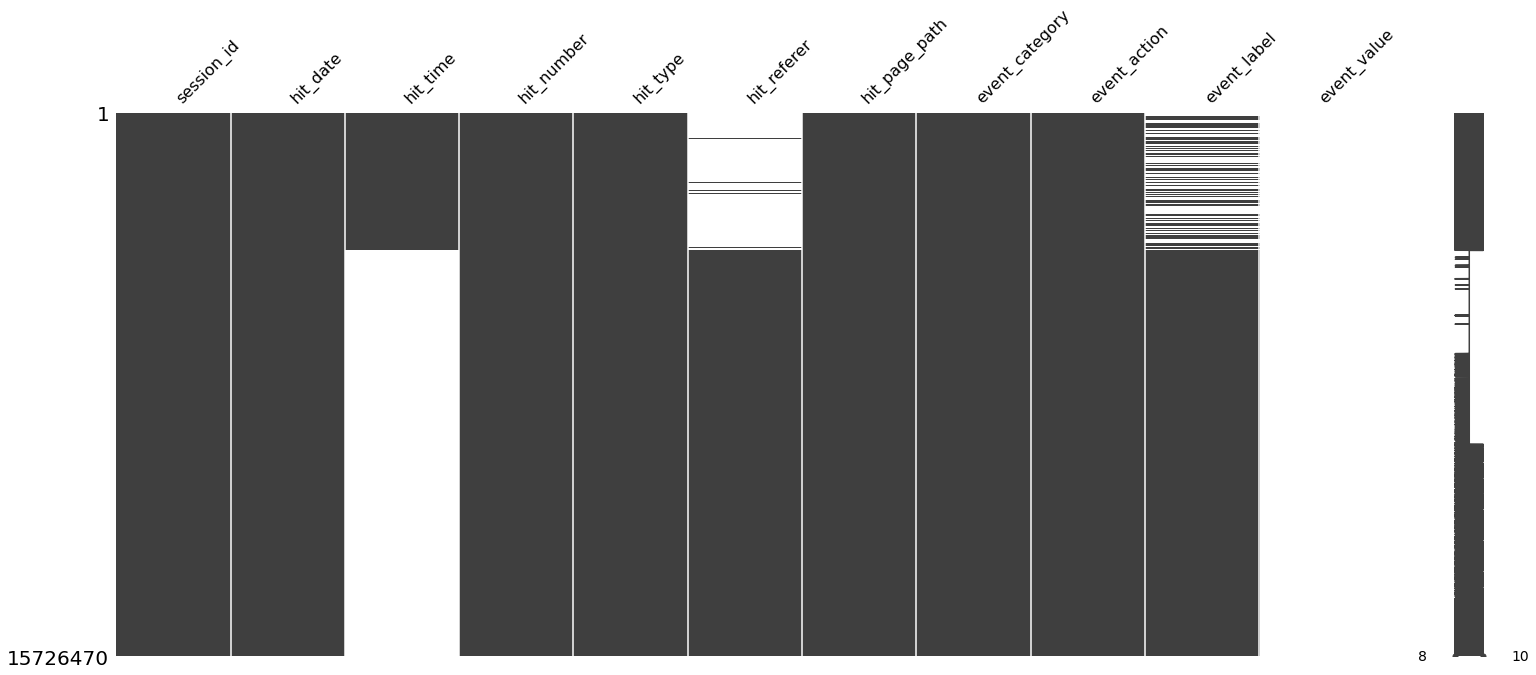

In [10]:
msno.matrix(df_hits)

#### Датафрейм для отдельной сессии

Посмотрим как выглядит часть датафрейма для одной сессии

In [11]:
oneses_df = df_hits[df_hits.session_id == '5639623078712724064.1640254056.1640254056']
oneses_df.sort_values('hit_number').head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
565528,5639623078712724064.1640254056.1640254056,2021-12-23,3236.0,3,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,search_form,search_form_search_btn,ghOrjqpgskpGHSFfBBsi,None
1687849,5639623078712724064.1640254056.1640254056,2021-12-23,249893.0,4,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,cars,view_more_click,pzAKUYdRKNEUXxxBFUPX,None
15165913,5639623078712724064.1640254056.1640254056,2021-12-23,289879.0,7,event,NaN,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_card,NaN,None
564154,5639623078712724064.1640254056.1640254056,2021-12-23,290039.0,8,event,NaN,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_new_card,NaN,None
15165914,5639623078712724064.1640254056.1640254056,2021-12-23,290048.0,9,event,NaN,sberauto.com/cars/all/kia/seltos/20f30855?utm_...,card_web,view_card,NaN,None


Здесь список всех зафиксированных пользователем действий на сайте и их характеристика в рамкка одной сессии. Нам нужно для каждой сессии проверить было ли совершено целевое действие и записать результат в session dataframe

Список всех целевых действий:
(df_hits.event_action in 
['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'])

### Dataframe join

Создадим словарь со значениями event_action, которые соответствуют целевому действию

In [12]:
target_action_list = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

In [13]:
df = df_ses.copy()

Создадим датафрейм, где для каждой сессии проверены все действия пользователя, если среди неих есть целевые => записываем в переменную target единицу, в остальных случаях 0.

P.S. Если было совершено большего одного целевого действия за сессию, всё равно считаем за 1

In [14]:
df_hits['target'] = df_hits['event_action'].apply(lambda x: 1 if x in target_action_list else 0)
pivot_hits = pd.pivot_table(
    df_hits,
    index='session_id',
    values='target',
    aggfunc='sum'
)
pivot_hits['target'] = pivot_hits['target'].apply(lambda x: 1 if x > 1 else x)

Объеденим датафреймы

In [15]:
df = df.merge(pivot_hits, how='left', left_on='session_id', right_index=True)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


Проверим появились ли незаполненые значения после объединения датафреймов

<AxesSubplot:>

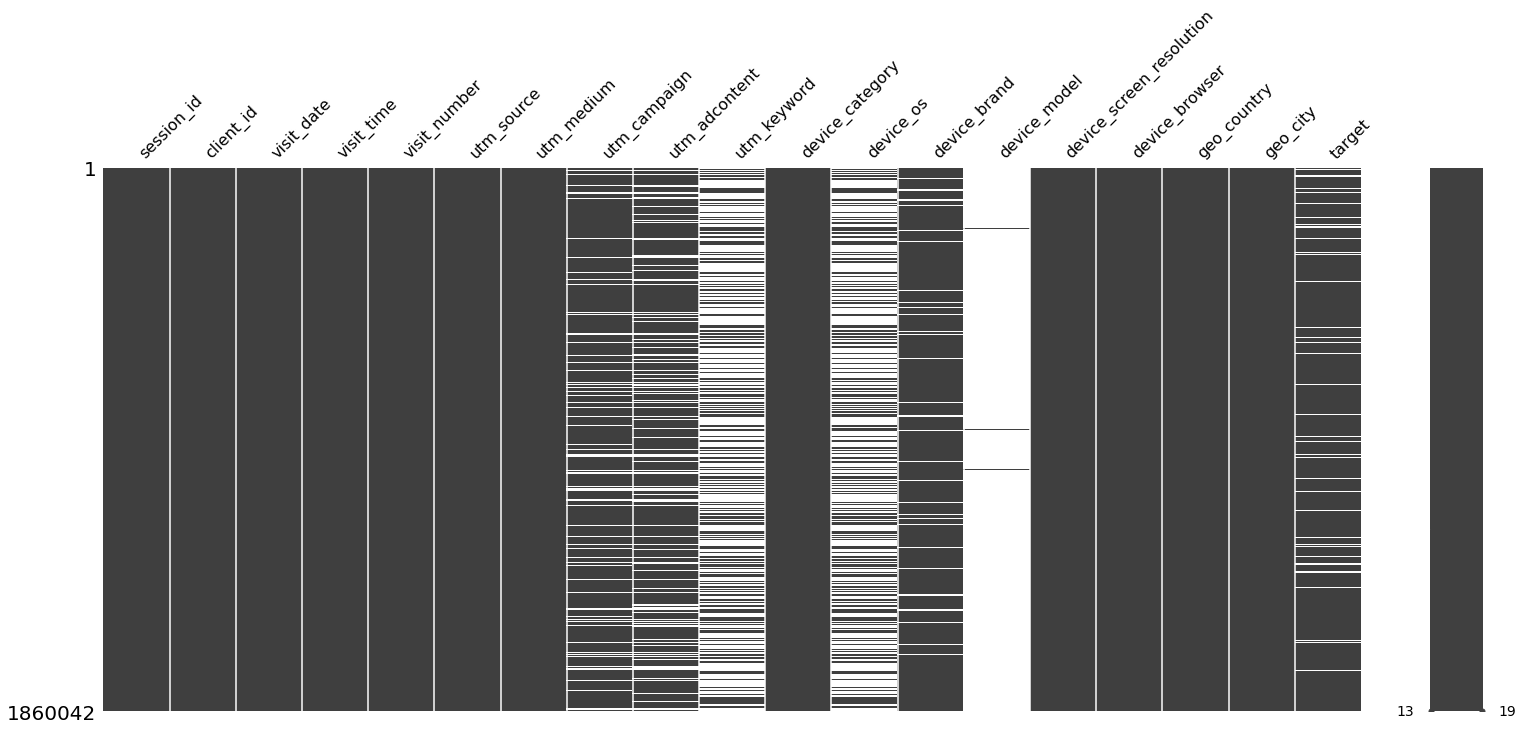

In [16]:
msno.matrix(df)

In [17]:
print(f'Процент пропущенных значений в target {round(df.target.isna().sum()/len(df) * 100, 2)} %')

Процент пропущенных значений в target 6.87 %


Сохраним получившийся датафрейм, чтобы при новом запуске не приходилось заново запускать все шаги

In [18]:
with open('data/combine_data.pkl', 'wb') as file:
    pickle.dump(df, file)

## Data cleaning

In [19]:
with open('data/combine_data.pkl', 'rb') as file:
    df = pickle.load(file)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


In [20]:
df_clean = df.copy()

### Удаление данных

#### drop columns [visit_date,	visit_time, device_model, visit_number]

Удалим почти полностью пустую фичу device_model (Можно было бы попытаться восстановить на основе данных о дисплее и ОС, но в них и так косвенно содержится нужная информация)

In [21]:
columns_to_drop = ['visit_date', 'visit_time', 'device_model']
df_clean = df_clean.drop(columns=columns_to_drop, axis=1)

#### utm_keyword

In [22]:
df_clean.utm_keyword.value_counts(dropna=False)

NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
                         ...   
XsuVVTgiDIxZtndPjvDm          1
WhaUakldaAmpLumfaADO          1
nJVPLgfxsBtPAXttNVDI          1
nwKBdMZKktIQFvhZwbFe          1
fcXWTQaKfxbkBkBnzLhK          1
Name: utm_keyword, Length: 1220, dtype: int64

In [23]:
print(f"Процент пропущенных значений в utm_keyword: {round(df_clean.utm_keyword.isna().sum()/len(df) * 100)} %")

Процент пропущенных значений в utm_keyword: 58 %


Удалим этот столбец, т.к. пропущенных значений больше половины, а сгенирировать их не получится

In [24]:
df_clean = df_clean.drop(columns='utm_keyword')

#### target

Теперь удалим строки с пустым значением target

In [25]:
df_clean = df_clean.dropna(subset='target')

In [26]:
missing_values = (df_clean.isna().sum() / len(df_clean) * 100).sort_values(ascending=False)
print("Процент пропущенных значений")
missing_values

Процент пропущенных значений


device_os                   58.533966
utm_adcontent               17.557177
utm_campaign                11.273500
device_brand                 6.358030
utm_source                   0.004387
session_id                   0.000000
client_id                    0.000000
visit_number                 0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target                       0.000000
dtype: float64

### Заполнение пропущенных данных 

#### utm_source

In [27]:
df_clean.utm_source.describe()

count                  1732190
unique                     280
top       ZpYIoDJMcFzVoPFsHGJL
freq                    552555
Name: utm_source, dtype: object

In [28]:
df_clean.utm_source.value_counts()

ZpYIoDJMcFzVoPFsHGJL    552555
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
                         ...  
DWvtKQncdpXXfLBjBmGj         1
ZsHOHNXkbhgIDlKNiFMf         1
hYVrCkhCPSqKBhZYhWVq         1
OboZzsWwJIeGPLeiLGMq         1
sbJRYgVfvcnqKJNDDYIr         1
Name: utm_source, Length: 280, dtype: int64

Запишем в пропуски параметр 'no_specified'

In [29]:
df_clean['utm_source'] = df_clean.utm_source.fillna('no_specified')

#### device_brand

In [30]:
df_clean.device_brand.describe()

count     1622128
unique        201
top         Apple
freq       503533
Name: device_brand, dtype: object

In [31]:
df_clean.device_brand.value_counts(dropna=False)

Apple       503533
Samsung     311641
Xiaomi      269251
            237058
Huawei      173828
             ...  
Tesla            1
Vodafone         1
Wexler           1
Smarteo          1
Maxvi            1
Name: device_brand, Length: 202, dtype: int64

Также в device_brand на 4 месте по частоте стоит параметр, который формально не является пропуском т.к. является строкой без значений. Скорее всего это персональные компьютеры

In [32]:
df_clean[df_clean.device_brand == ''].device_category.value_counts()

desktop    236704
mobile        215
tablet        139
Name: device_category, dtype: int64

Заполним значения 'device_brand' как 'pc' там где device_category = 'desktop'

In [33]:
def is_pc(sample):
    if sample.device_brand == '' and sample.device_category == 'desktop':
        return 'pc'
    return sample.device_brand

In [34]:
df_clean['device_brand'] = df_clean.apply(is_pc, axis=1)

оставшиеся значения заполним параметром (not set)

In [35]:
df_clean['device_brand'] = df_clean.device_brand.apply(lambda x: "(not set)" if x == '' else x)

Теперь пропущенные значения заполним параметром "other"

In [36]:
df_clean['device_brand'] = df_clean.device_brand.fillna('other')

#### device_os

In [37]:
df_clean.device_os.value_counts(dropna=False)

None             1013964
Android           425520
iOS               182597
Windows            81740
Macintosh          23415
Linux               4616
(not set)            309
Chrome OS             65
BlackBerry            24
Tizen                  7
Firefox OS             3
Nokia                  2
Samsung                2
Windows Phone          2
Name: device_os, dtype: int64

In [38]:
df_clean.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,None,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,None,Xiaomi,393x786,Chrome,Russia,Moscow,0.0


In [39]:
def find_os(data):
    if data.device_os is None:
        if data.device_category == 'desktop':
            if data.device_brand == 'Apple' or data.device_browser == 'Safari':
                return 'Macintosh'
            else:
                return 'other'
        else:
            if data.device_browser == 'Safari' or data.device_brand == 'Apple':
                return 'iOS'
            else:
                return 'Android'
    else:
        return data.device_os

In [40]:
df_clean['device_os'] = df_clean.apply(find_os, axis=1)

In [41]:
df_clean.device_os.value_counts(dropna=False)

Android          881667
iOS              503624
other            210766
Windows           81740
Macintosh         49439
Linux              4616
(not set)           309
Chrome OS            65
BlackBerry           24
Tizen                 7
Firefox OS            3
Nokia                 2
Samsung               2
Windows Phone         2
Name: device_os, dtype: int64

#### utm_campaign

In [42]:
df_clean.utm_campaign.describe()

count                  1536979
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422992
Name: utm_campaign, dtype: object

In [43]:
df_clean.utm_campaign.value_counts()

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
                         ...  
zXjuoqEaPElBnwpSHMpx         1
cqgnjDbqrtCipVvzhxqa         1
AdtHYglxfCpTpwZeTAuW         1
qPDTdivQVeflLjTYIJnG         1
cXxuwXPoQCvAXPHpFcZl         1
Name: utm_campaign, Length: 406, dtype: int64

Пропуски заполним значением 'no_specified'

In [44]:
df_clean['utm_campaign'] = df_clean.utm_campaign.fillna('no_specified')

#### utm_adcontent

In [45]:
df_clean.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    935408
NaN                     304137
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
                         ...  
zQEFTgQvqExfbldEpotc         1
JgmeMvxiYyrYlmqauiSv         1
aVjToAjFPhYtOzTWvULR         1
QMmfrhgnqNOwSTPaqlLK         1
oJivRDNIrrOckRBIKOtG         1
Name: utm_adcontent, Length: 281, dtype: int64

Можно удалить столбец т.к. пропущен большой процент значений, но в данном случае отсутствие информации - тоже информация поэтому впишем значение 'no_specified' 

In [46]:
df_clean['utm_adcontent'] = df_clean.utm_adcontent.fillna('no_specified')

### Cleaning Итоги

<AxesSubplot:>

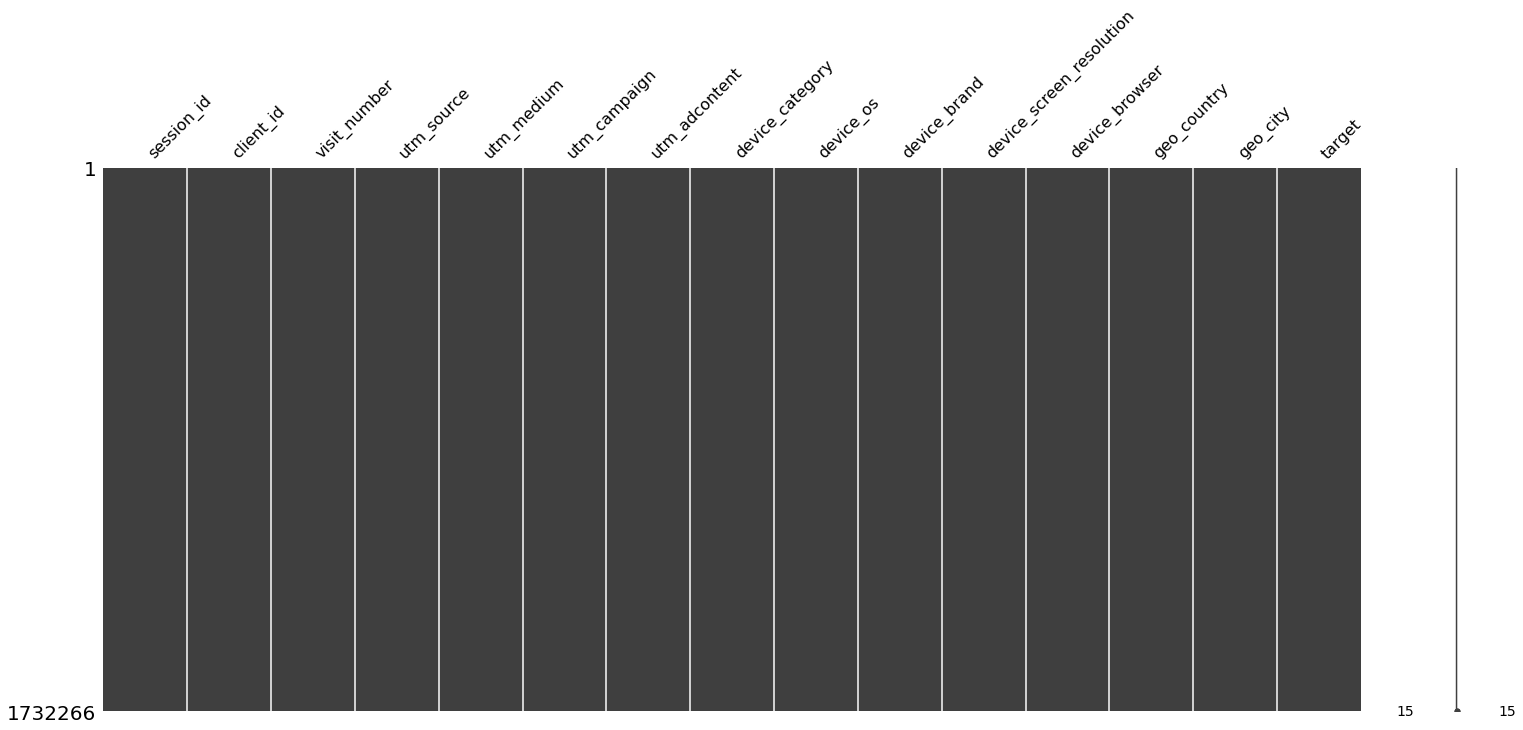

In [47]:
msno.matrix(df_clean)

In [48]:
missing_values = (df_clean.isna().sum() / len(df_clean) * 100).sort_values(ascending=False)
print("Процент пропущенных значений")
missing_values

Процент пропущенных значений


session_id                  0.0
client_id                   0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
target                      0.0
dtype: float64

Данные подготовлены к следующему этапу и очищены от пропусков.

In [49]:
with open('data/clean_data.pkl', 'wb') as file:
    pickle.dump(df_clean, file)

## Feature engineering

In [50]:
with open('data/clean_data.pkl', 'rb') as file:
    df_clean = pickle.load(file)
print(f"Размер датафрейма: Колонок - {df_clean.shape[1]}, Строк - {df_clean.shape[0]}")
df_clean.head(5)

Размер датафрейма: Колонок - 15, Строк - 1732266


,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,no_specified,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,no_specified,no_specified,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0.0


In [51]:
df = df_clean.copy()

### Удаление редких значений

#### utm_ * , geo_ * , device_ *

In [52]:
reduce_list = [
    'utm_source',
    'utm_medium',
    'utm_campaign',
    'utm_adcontent',
    'device_brand',
    'device_browser',
    'geo_country',
    'geo_city'
]

def most_freq_val(df):
    for element in reduce_list:
        print(element)
        print(f"Количество уникальных значений: {element}: {df[element].nunique()}")
        print(f"Процент топ 5 значений: {df[element].value_counts().head(5).sum() / len(df) * 100}")
        print(f"Процент 5 самых редких: {df[element].value_counts().tail(5).sum() / len(df) *100} \n")

In [53]:
most_freq_val(df)

utm_source
Количество уникальных значений: utm_source: 281
Процент топ 5 значений: 78.60149653690598
Процент 5 самых редких: 0.0002886392736450407 

utm_medium
Количество уникальных значений: utm_medium: 55
Процент топ 5 значений: 90.53476775506763
Процент 5 самых редких: 0.0002886392736450407 

utm_campaign
Количество уникальных значений: utm_campaign: 407
Процент топ 5 значений: 75.49429475611713
Процент 5 самых редких: 0.0002886392736450407 

utm_adcontent
Количество уникальных значений: utm_adcontent: 281
Процент топ 5 значений: 91.34867277889192
Процент 5 самых редких: 0.0002886392736450407 

device_brand
Количество уникальных значений: device_brand: 202
Процент топ 5 значений: 86.30066052211382
Процент 5 самых редких: 0.0002886392736450407 

device_browser
Количество уникальных значений: device_browser: 55
Процент топ 5 значений: 94.09143861277656
Процент 5 самых редких: 0.0002886392736450407 

geo_country
Количество уникальных значений: geo_country: 159
Процент топ 5 значений: 9

Много данных которые встречаются крайне редко. Введем ограничение: все значения, которые встречаются реже чем в 0.01% проценте случаев будут 'other'

In [54]:
for element in reduce_list:

    a = df[element].value_counts()/len(df)*100
    most_freq_elem = a[a > 0.01].index.to_list()
    df[element] = df[element].apply(lambda x: 'other' if x not in most_freq_elem else x)

In [55]:
most_freq_val(df)

utm_source
Количество уникальных значений: utm_source: 55
Процент топ 5 значений: 78.60149653690598
Процент 5 самых редких: 0.08024171807332131 

utm_medium
Количество уникальных значений: utm_medium: 25
Процент топ 5 значений: 90.53476775506763
Процент 5 самых редких: 0.12798265393421102 

utm_campaign
Количество уникальных значений: utm_campaign: 149
Процент топ 5 значений: 75.49429475611713
Процент 5 самых редких: 0.05622693050605392 

utm_adcontent
Количество уникальных значений: utm_adcontent: 66
Процент топ 5 значений: 91.34867277889192
Процент 5 самых редких: 0.06927342567480976 

device_brand
Количество уникальных значений: device_brand: 42
Процент топ 5 значений: 86.30066052211382
Процент 5 самых редких: 0.056919664762802025 

device_browser
Количество уникальных значений: device_browser: 13
Процент топ 5 значений: 94.09143861277656
Процент 5 самых редких: 0.9956323105112033 

geo_country
Количество уникальных значений: geo_country: 43
Процент топ 5 значений: 98.47840920505281

В этих колонках мы отфилтровали наиболее редкие значения 

#### visit_number

In [56]:
df.visit_number.value_counts()

1      1301099
2       212176
3        71835
4        36600
5        21482
        ...   
418          1
419          1
420          1
421          1
564          1
Name: visit_number, Length: 533, dtype: int64

Для нас наиболее информативными являются несколько первых визитов, в остальных случаях уже не так важно сколько их было, скорее важно, что их больше определенного значения

In [57]:
def visit_count(visit):
    if visit <= 5:
        return "visit_" + str(visit)
    else:
        return "visit_over_5"

In [58]:
df['visit_number'] = df.visit_number.apply(visit_count)

In [59]:
df.visit_number.value_counts()

visit_1         1301099
visit_2          212176
visit_over_5      89074
visit_3           71835
visit_4           36600
visit_5           21482
Name: visit_number, dtype: int64

### Генерация новых фич

### pixels

In [60]:
df['pixels'] = df.device_screen_resolution.apply(lambda x: int(x.split('x')[0]) *  int(x.split('x')[1]))

In [61]:
df.device_screen_resolution.value_counts().head(10)

414x896      155140
1920x1080    119214
393x851      107972
375x812      106961
360x780       86718
375x667       86131
360x800       75168
412x915       70484
360x640       65796
390x844       55382
Name: device_screen_resolution, dtype: int64

In [62]:
df.pixels.value_counts(dropna=False)

370944     155140
2073600    119299
334443     114529
304500     106961
280800      89979
            ...  
274824          1
273004          1
936192          1
1064960         1
521072          1
Name: pixels, Length: 4506, dtype: int64

In [63]:
df.pixels.describe().apply("{0:.0f}".format)

count     1732266
mean       609145
std        705158
min             0
25%        280800
50%        334443
75%        376980
max      32000000
Name: pixels, dtype: object

In [64]:
df.pixels[df.pixels < 360*640].describe().apply("{0:.0f}".format)

count     69529
mean     201119
std       19559
min           0
25%      181760
50%      204800
75%      221760
max      230298
Name: pixels, dtype: object

In [65]:
df.pixels[df.pixels > 3840*2160].describe().apply("{0:.0f}".format)

count          49
mean     24879830
std       9066145
min       8678400
25%      20971520
50%      32000000
75%      32000000
max      32000000
Name: pixels, dtype: object

In [66]:
(3840*2160) / (360*640)

36.0

За нижнюю границу примем самое маленькое из то 10 значений (360 х 640), а за верхнюю 4к мониторы (3840 х 2160)

In [67]:
def pixels_outliers(pixels):
    if pixels > (3840*2160):
        return (3840*2160)
    elif pixels < (360*640):
        return (360*640)
    else:
        return pixels

In [68]:
df['pixels'] = df.pixels.apply(pixels_outliers)

In [69]:
df.pixels.describe().apply("{0:.0f}".format)

count    1732266
mean      609851
std       692126
min       230400
25%       280800
50%       334443
75%       376980
max      8294400
Name: pixels, dtype: object

#### aspect_ratio

In [70]:
def find_aspect_ratio(data):
    diagonals = data.split('x')
    if int(diagonals[1]) == 0:
        return 1
    else:
        return int(diagonals[0]) / int(diagonals[1])

In [71]:
df['aspect_ratio'] = df.device_screen_resolution.apply(find_aspect_ratio)

In [72]:
df.aspect_ratio.describe().apply("{0:.0f}".format)

count    1732266
mean           1
std            1
min            0
25%            0
50%            0
75%            1
max            5
Name: aspect_ratio, dtype: object

In [73]:
df.aspect_ratio.value_counts()

1.777778    206373
0.462054    155141
0.461810    107972
0.461823    106961
0.562500     96330
             ...  
1.519466         1
0.451080         1
0.412664         1
0.469388         1
0.413179         1
Name: aspect_ratio, Length: 4341, dtype: int64

 #### device_screen_resolution drop

Удалим колонку device_screen_resolution - все необходимые данные мы из нее отобрали

In [74]:
df = df.drop(columns='device_screen_resolution')

### organic trafic

In [75]:
organic_traf_list = ['organic', 'referal', '(none)']

In [76]:
df['is_organic'] = df.utm_medium.apply(lambda x: 1 if x in organic_traf_list else 0)
df

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target,pixels,aspect_ratio,is_organic
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0.0,259200,0.500000,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,visit_1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0.0,328790,0.450820,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0.0,259200,0.500000,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,visit_1,kjsLglQLzykiRbcDiGcD,cpc,no_specified,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.500000,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,visit_2,kjsLglQLzykiRbcDiGcD,cpc,no_specified,no_specified,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,visit_1,BHcvLfOaCWvWTykYqHVe,cpc,no_specified,no_specified,desktop,Windows,other,Chrome,Russia,Moscow,0.0,2073600,1.777778,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,visit_1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,0.0,329160,0.462085,1
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,visit_1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,0.0,250125,0.562219,1
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0.0,334443,0.461810,0


#### social_media_ad

In [77]:
sm_ad_list = [
    'QxAxdyPLuQMEcrdZWdWb',
    'MvfHsxITijuriZxsqZqt',
    'ISrKoXQCxqqYvAZICvjs',
    'IZEXUFLARCUMynmHNBGo',
    'PlbkrSYoHuZBWfYjYnfw',
    'gVRrcxiDQubJiljoTbGm'
]

In [78]:
df['is_sm_ad'] = df.utm_source.apply(lambda x: 1 if x in sm_ad_list else 0)
df

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target,pixels,aspect_ratio,is_organic,is_sm_ad
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0.0,259200,0.500000,0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,visit_1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0.0,328790,0.450820,0,1
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0.0,259200,0.500000,0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,visit_1,kjsLglQLzykiRbcDiGcD,cpc,no_specified,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.500000,0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,visit_2,kjsLglQLzykiRbcDiGcD,cpc,no_specified,no_specified,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.500000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,visit_1,BHcvLfOaCWvWTykYqHVe,cpc,no_specified,no_specified,desktop,Windows,other,Chrome,Russia,Moscow,0.0,2073600,1.777778,0,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,visit_1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,0.0,329160,0.462085,1,0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,visit_1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,0.0,250125,0.562219,1,0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0.0,334443,0.461810,0,0


In [79]:
with open('data/prep_data.pkl', 'wb') as file:
    pickle.dump(df, file)

### Визуализация данных / нахождение основных зависимостей

In [80]:
with open('data/prep_data.pkl', 'rb') as file:
    df = pickle.load(file)
print(f"Размер датафрейма: Колонок - {df.shape[1]}, Строк - {df.shape[0]}")
df.head(5)

Размер датафрейма: Колонок - 18, Строк - 1732266


,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target,pixels,aspect_ratio,is_organic,is_sm_ad
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0.0,259200,0.50000,0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,visit_1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0.0,328790,0.45082,0,1
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0.0,259200,0.50000,0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,visit_1,kjsLglQLzykiRbcDiGcD,cpc,no_specified,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.50000,0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,visit_2,kjsLglQLzykiRbcDiGcD,cpc,no_specified,no_specified,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.50000,0,0


Создадим функцию, которая принимает название фичи и выводит датафрейм с количеством параметров этой фичи, количеством параметров в случае положительного значения таргета, процент значений каждого параметра с положительным значением таргета.

In [81]:
def statistic_dataframe(feature, df=df):
    df_new = pd.DataFrame({
    'parametr': df[feature].value_counts().index.to_list(),
    'Values': df[feature].value_counts().to_list(),
    })
    
    targeted_values = df[df.target == 1][feature].value_counts()
    df_new = df_new.merge(targeted_values, left_on='parametr', right_index=True, how='left')
    df_new = df_new.rename(columns= {feature: 'values_targeted'})
    df_new['percent_targeted'] = df_new.apply(lambda x: x.values_targeted / x.Values * 100, axis=1)
    
    return df_new

Посмоторим как влияет тип устройства на факт совершения целевого действия.

In [82]:
device_stat = statistic_dataframe('device_category')
device_stat

,parametr,Values,values_targeted,percent_targeted
0,mobile,1368679,38379,2.804091
1,desktop,346891,11513,3.318910
2,tablet,16696,422,2.527552


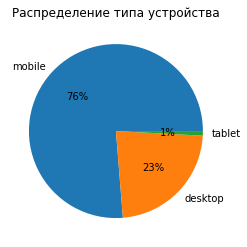

In [83]:
plt.pie(device_stat.values_targeted, labels=device_stat.parametr, autopct='%1.0f%%')
plt.title("Распределение типа устройства")
plt.show();

In [84]:
cities_stat = statistic_dataframe('geo_city')
cities_stat = cities_stat.sort_values('values_targeted', ascending=False)
cities_stat.head(10)

,parametr,Values,values_targeted,percent_targeted
0,Moscow,750928,23629.0,3.146640
1,Saint Petersburg,278402,7113.0,2.554939
2,(not set),73297,1588.0,2.166528
5,Kazan,27689,1139.0,4.113547
4,Krasnodar,30260,1081.0,3.572373
3,Yekaterinburg,33555,887.0,2.643421
7,Samara,23433,727.0,3.102462
6,other,27174,725.0,2.667991
9,Ufa,20283,639.0,3.150422
8,Nizhny Novgorod,20782,559.0,2.689828


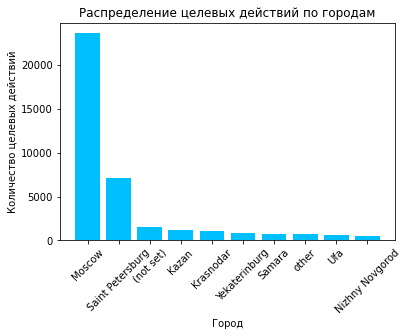

In [85]:
plt.bar(cities_stat.parametr.head(10), cities_stat.values_targeted.head(10), color='deepskyblue')
plt.xticks(rotation=45)
plt.xlabel('Город')
plt.ylabel('Количество целевых действий')
plt.title('Распределение целевых действий по городам');

Как видно из графиков основные конверсии происходят от пользователей с мобильными устройствами и персональными компьютерами, а также из двух крупнейших городов России - Москвы и Санкт-Петербурга. 
Но если посмотрим на процент конверсий из кадой категории - он плюс минус такой же.

Посмотрим как влияет какой был трафик (органический или нет) на показатель конверсии

In [86]:
organic_stat = statistic_dataframe('is_organic')
organic_stat

,parametr,Values,values_targeted,percent_targeted
0,0,1400197,37683,2.691264
1,1,332069,12631,3.803728


Среди тех кто пришел из органического трафика - конверсия немного выше, но их число заметно меньше

In [87]:
sm_stat = statistic_dataframe('is_sm_ad')
sm_stat

,parametr,Values,values_targeted,percent_targeted
0,0,1475986,46293,3.136412
1,1,256280,4021,1.568987


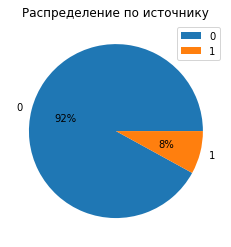

In [88]:
plt.pie(sm_stat.values_targeted, labels=sm_stat.parametr, autopct='%1.0f%%')
plt.title("Распределение по источнику")
plt.legend()
plt.show();

Трафика из соцсетей (1) - гораздо меньше чем из других источников, при этом процент конверсии из этого источника примерно в 2 раза ниже. 

In [89]:
with open('data/prep_data.pkl', 'wb') as file:
    pickle.dump(df, file)

## Modeling

In [2]:
with open('data/prep_data.pkl', 'rb') as file:
    df = pickle.load(file)
print(f"Размер датафрейма: Колонок - {df.shape[1]}, Строк - {df.shape[0]}")
df.head(5)

Размер датафрейма: Колонок - 18, Строк - 1732266


,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target,pixels,aspect_ratio,is_organic,is_sm_ad
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0.0,259200,0.50000,0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,visit_1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0.0,328790,0.45082,0,1
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,visit_1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0.0,259200,0.50000,0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,visit_1,kjsLglQLzykiRbcDiGcD,cpc,no_specified,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.50000,0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,visit_2,kjsLglQLzykiRbcDiGcD,cpc,no_specified,no_specified,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0.0,308898,0.50000,0,0


### feture encoding

In [3]:
df = df.drop(columns=['session_id', 'client_id'])

In [4]:
enc_col = df.drop(columns='target').columns.to_list()
enc_col

['visit_number',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_category',
 'device_os',
 'device_brand',
 'device_browser',
 'geo_country',
 'geo_city',
 'pixels',
 'aspect_ratio',
 'is_organic',
 'is_sm_ad']

In [5]:
ohe = OneHotEncoder()

In [6]:
ohe.fit(df[enc_col])
x = ohe.transform(df[enc_col])

In [7]:
x

<1732266x9256 sparse matrix of type '<class 'numpy.float64'>'
	with 25983990 stored elements in Compressed Sparse Row format>

In [8]:
y = df.target

#### train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42, stratify=y)

### log regression

In [98]:
logreg = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42)

In [99]:
logreg.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

In [100]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

In [101]:
y_test_proba = logreg.predict_proba(x_test)

In [102]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[285401, 219185],
       [  4504,  10590]], dtype=int64)

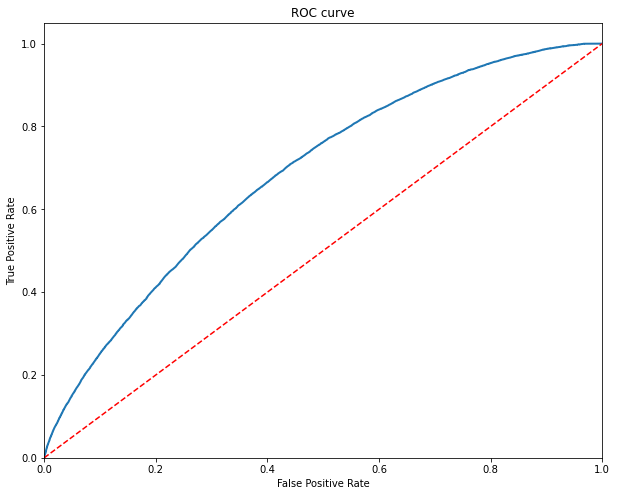

In [103]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [104]:
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.6857939918488847


### RandomForest

In [111]:
rnf = RandomForestClassifier(n_jobs=-1, max_depth=30)
rnf.fit(x_train, y_train)
y_test_proba = rnf.predict_proba(x_test)

In [112]:
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_proba[:, 1])}')

ROC-AUC: 0.6824915705795181


### XGBoost

In [113]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_test_proba = xgb.predict_proba(x_test)

In [114]:
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_proba[:, 1])}')

ROC-AUC: 0.6958259583132658


### XGB optuna

In [10]:
def objective(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
   
    model = XGBClassifier(random_state=42, 
                             tree_method='gpu_hist', 
                             gpu_id=0, 
                             predictor="gpu_predictor",
                             **param)  
    
    model.fit(x_train, y_train)
    y_test_proba = model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])
    return roc_auc

In [18]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

In [19]:
# study.best_params

In [20]:
best_params_xgb = {'max_depth': 11,
 'subsample': 0.8,
 'n_estimators': 1400,
 'eta': 0.02,
 'reg_alpha': 3,
 'reg_lambda': 6,
 'min_child_weight': 7,
 'colsample_bytree': 0.5691100175656586}

### Catboost

In [15]:
cat = CatBoostClassifier(task_type='GPU')
cat.fit(x_train, y_train)
y_test_proba = cat.predict_proba(x_test)

Learning rate set to 0.022812
0:	learn: 0.6554127	total: 33ms	remaining: 33s
1:	learn: 0.6203305	total: 69.9ms	remaining: 34.9s
2:	learn: 0.5881512	total: 103ms	remaining: 34.3s
3:	learn: 0.5580968	total: 136ms	remaining: 33.9s
4:	learn: 0.5296634	total: 176ms	remaining: 34.9s
5:	learn: 0.5031454	total: 212ms	remaining: 35.1s
6:	learn: 0.4787719	total: 244ms	remaining: 34.7s
7:	learn: 0.4556669	total: 264ms	remaining: 32.7s
8:	learn: 0.4345027	total: 281ms	remaining: 31s
9:	learn: 0.4146244	total: 300ms	remaining: 29.7s
10:	learn: 0.3960301	total: 320ms	remaining: 28.8s
11:	learn: 0.3789272	total: 339ms	remaining: 27.9s
12:	learn: 0.3626606	total: 363ms	remaining: 27.5s
13:	learn: 0.3478303	total: 382ms	remaining: 26.9s
14:	learn: 0.3340099	total: 400ms	remaining: 26.3s
15:	learn: 0.3211312	total: 418ms	remaining: 25.7s
16:	learn: 0.3090872	total: 438ms	remaining: 25.3s
17:	learn: 0.2978968	total: 457ms	remaining: 24.9s
18:	learn: 0.2873040	total: 477ms	remaining: 24.6s
19:	learn: 0.27

163:	learn: 0.1263984	total: 3.69s	remaining: 18.8s
164:	learn: 0.1263837	total: 3.71s	remaining: 18.8s
165:	learn: 0.1263625	total: 3.73s	remaining: 18.8s
166:	learn: 0.1263450	total: 3.75s	remaining: 18.7s
167:	learn: 0.1263344	total: 3.77s	remaining: 18.7s
168:	learn: 0.1263230	total: 3.8s	remaining: 18.7s
169:	learn: 0.1263151	total: 3.82s	remaining: 18.6s
170:	learn: 0.1263006	total: 3.84s	remaining: 18.6s
171:	learn: 0.1262895	total: 3.86s	remaining: 18.6s
172:	learn: 0.1262803	total: 3.88s	remaining: 18.5s
173:	learn: 0.1262682	total: 3.9s	remaining: 18.5s
174:	learn: 0.1262578	total: 3.92s	remaining: 18.5s
175:	learn: 0.1262480	total: 3.95s	remaining: 18.5s
176:	learn: 0.1262388	total: 3.97s	remaining: 18.5s
177:	learn: 0.1262222	total: 4s	remaining: 18.4s
178:	learn: 0.1262043	total: 4.02s	remaining: 18.4s
179:	learn: 0.1261936	total: 4.04s	remaining: 18.4s
180:	learn: 0.1261829	total: 4.06s	remaining: 18.4s
181:	learn: 0.1261752	total: 4.08s	remaining: 18.3s
182:	learn: 0.126

328:	learn: 0.1253599	total: 6.99s	remaining: 14.2s
329:	learn: 0.1253564	total: 7.01s	remaining: 14.2s
330:	learn: 0.1253536	total: 7.03s	remaining: 14.2s
331:	learn: 0.1253515	total: 7.05s	remaining: 14.2s
332:	learn: 0.1253491	total: 7.07s	remaining: 14.2s
333:	learn: 0.1253406	total: 7.09s	remaining: 14.1s
334:	learn: 0.1253382	total: 7.11s	remaining: 14.1s
335:	learn: 0.1253366	total: 7.13s	remaining: 14.1s
336:	learn: 0.1253342	total: 7.15s	remaining: 14.1s
337:	learn: 0.1253306	total: 7.17s	remaining: 14s
338:	learn: 0.1253275	total: 7.18s	remaining: 14s
339:	learn: 0.1253211	total: 7.21s	remaining: 14s
340:	learn: 0.1253192	total: 7.22s	remaining: 14s
341:	learn: 0.1253184	total: 7.24s	remaining: 13.9s
342:	learn: 0.1253150	total: 7.26s	remaining: 13.9s
343:	learn: 0.1253138	total: 7.27s	remaining: 13.9s
344:	learn: 0.1253115	total: 7.29s	remaining: 13.8s
345:	learn: 0.1253089	total: 7.31s	remaining: 13.8s
346:	learn: 0.1253070	total: 7.32s	remaining: 13.8s
347:	learn: 0.125306

490:	learn: 0.1249303	total: 10.1s	remaining: 10.4s
491:	learn: 0.1249277	total: 10.1s	remaining: 10.4s
492:	learn: 0.1249264	total: 10.1s	remaining: 10.4s
493:	learn: 0.1249239	total: 10.1s	remaining: 10.4s
494:	learn: 0.1249222	total: 10.1s	remaining: 10.4s
495:	learn: 0.1249213	total: 10.2s	remaining: 10.3s
496:	learn: 0.1249189	total: 10.2s	remaining: 10.3s
497:	learn: 0.1249166	total: 10.2s	remaining: 10.3s
498:	learn: 0.1249158	total: 10.2s	remaining: 10.3s
499:	learn: 0.1249141	total: 10.2s	remaining: 10.2s
500:	learn: 0.1249123	total: 10.3s	remaining: 10.2s
501:	learn: 0.1249117	total: 10.3s	remaining: 10.2s
502:	learn: 0.1249108	total: 10.3s	remaining: 10.2s
503:	learn: 0.1249104	total: 10.3s	remaining: 10.1s
504:	learn: 0.1249074	total: 10.3s	remaining: 10.1s
505:	learn: 0.1249060	total: 10.3s	remaining: 10.1s
506:	learn: 0.1249039	total: 10.4s	remaining: 10.1s
507:	learn: 0.1249036	total: 10.4s	remaining: 10.1s
508:	learn: 0.1249024	total: 10.4s	remaining: 10s
509:	learn: 0.

658:	learn: 0.1246770	total: 13.1s	remaining: 6.8s
659:	learn: 0.1246766	total: 13.2s	remaining: 6.78s
660:	learn: 0.1246758	total: 13.2s	remaining: 6.76s
661:	learn: 0.1246752	total: 13.2s	remaining: 6.74s
662:	learn: 0.1246699	total: 13.2s	remaining: 6.72s
663:	learn: 0.1246693	total: 13.2s	remaining: 6.7s
664:	learn: 0.1246685	total: 13.3s	remaining: 6.68s
665:	learn: 0.1246673	total: 13.3s	remaining: 6.66s
666:	learn: 0.1246658	total: 13.3s	remaining: 6.64s
667:	learn: 0.1246647	total: 13.3s	remaining: 6.62s
668:	learn: 0.1246625	total: 13.3s	remaining: 6.6s
669:	learn: 0.1246605	total: 13.4s	remaining: 6.58s
670:	learn: 0.1246587	total: 13.4s	remaining: 6.56s
671:	learn: 0.1246570	total: 13.4s	remaining: 6.54s
672:	learn: 0.1246549	total: 13.4s	remaining: 6.52s
673:	learn: 0.1246537	total: 13.4s	remaining: 6.5s
674:	learn: 0.1246526	total: 13.4s	remaining: 6.47s
675:	learn: 0.1246516	total: 13.5s	remaining: 6.45s
676:	learn: 0.1246507	total: 13.5s	remaining: 6.43s
677:	learn: 0.12

826:	learn: 0.1244564	total: 16.2s	remaining: 3.4s
827:	learn: 0.1244547	total: 16.3s	remaining: 3.38s
828:	learn: 0.1244533	total: 16.3s	remaining: 3.36s
829:	learn: 0.1244526	total: 16.3s	remaining: 3.34s
830:	learn: 0.1244518	total: 16.3s	remaining: 3.32s
831:	learn: 0.1244502	total: 16.3s	remaining: 3.29s
832:	learn: 0.1244493	total: 16.3s	remaining: 3.28s
833:	learn: 0.1244491	total: 16.4s	remaining: 3.26s
834:	learn: 0.1244480	total: 16.4s	remaining: 3.24s
835:	learn: 0.1244475	total: 16.4s	remaining: 3.21s
836:	learn: 0.1244472	total: 16.4s	remaining: 3.19s
837:	learn: 0.1244452	total: 16.4s	remaining: 3.17s
838:	learn: 0.1244440	total: 16.4s	remaining: 3.16s
839:	learn: 0.1244436	total: 16.5s	remaining: 3.14s
840:	learn: 0.1244427	total: 16.5s	remaining: 3.12s
841:	learn: 0.1244416	total: 16.5s	remaining: 3.1s
842:	learn: 0.1244408	total: 16.5s	remaining: 3.08s
843:	learn: 0.1244386	total: 16.5s	remaining: 3.06s
844:	learn: 0.1244380	total: 16.6s	remaining: 3.04s
845:	learn: 0.

991:	learn: 0.1242780	total: 19.4s	remaining: 156ms
992:	learn: 0.1242776	total: 19.4s	remaining: 137ms
993:	learn: 0.1242766	total: 19.4s	remaining: 117ms
994:	learn: 0.1242749	total: 19.4s	remaining: 97.6ms
995:	learn: 0.1242743	total: 19.4s	remaining: 78ms
996:	learn: 0.1242737	total: 19.4s	remaining: 58.5ms
997:	learn: 0.1242729	total: 19.5s	remaining: 39ms
998:	learn: 0.1242722	total: 19.5s	remaining: 19.5ms
999:	learn: 0.1242707	total: 19.5s	remaining: 0us


In [16]:
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_proba[:, 1])}')

ROC-AUC: 0.6867527901714992


### 3 models 

In [9]:
from sklearn.model_selection import StratifiedKFold

In [11]:
best_params_xgb = {'max_depth': 11,
 'subsample': 0.8,
 'n_estimators': 1400,
 'eta': 0.02,
 'reg_alpha': 3,
 'reg_lambda': 6,
 'min_child_weight': 7,
 'colsample_bytree': 0.5691100175656586}

In [12]:
logreg = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42)
xgb = XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0, 
                             predictor="gpu_predictor",
                             **best_params_xgb)
cat = CatBoostClassifier(task_type='GPU')

models = {'logreg': logreg, 'xgb': xgb, 'cat': cat}

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, random_state=25, stratify=y)

skf = StratifiedKFold(n_splits=4)

In [17]:
df_preds = pd.DataFrame()

for model_name, model in models.items():
    model.fit(Xtrain, ytrain)
    print(f'Model {model_name} - training complete')
    df_preds[model_name] = model.predict_proba(Xtest)[:, 1]  

Model logreg - training complete
Model xgb - training complete
Learning rate set to 0.022812
0:	learn: 0.6554208	total: 31ms	remaining: 31s
1:	learn: 0.6207420	total: 61.9ms	remaining: 30.9s
2:	learn: 0.5883076	total: 93.9ms	remaining: 31.2s
3:	learn: 0.5582443	total: 125ms	remaining: 31s
4:	learn: 0.5298039	total: 162ms	remaining: 32.2s
5:	learn: 0.5032732	total: 196ms	remaining: 32.4s
6:	learn: 0.4788921	total: 226ms	remaining: 32s
7:	learn: 0.4557248	total: 259ms	remaining: 32.1s
8:	learn: 0.4342463	total: 278ms	remaining: 30.6s
9:	learn: 0.4143714	total: 294ms	remaining: 29.1s
10:	learn: 0.3960081	total: 311ms	remaining: 27.9s
11:	learn: 0.3789072	total: 327ms	remaining: 26.9s
12:	learn: 0.3627833	total: 345ms	remaining: 26.2s
13:	learn: 0.3479455	total: 361ms	remaining: 25.5s
14:	learn: 0.3338885	total: 381ms	remaining: 25s
15:	learn: 0.3209757	total: 398ms	remaining: 24.5s
16:	learn: 0.3089798	total: 413ms	remaining: 23.9s
17:	learn: 0.2977961	total: 429ms	remaining: 23.4s
18:	le

161:	learn: 0.1264558	total: 3.44s	remaining: 17.8s
162:	learn: 0.1264432	total: 3.46s	remaining: 17.8s
163:	learn: 0.1264278	total: 3.48s	remaining: 17.8s
164:	learn: 0.1264204	total: 3.5s	remaining: 17.7s
165:	learn: 0.1264027	total: 3.52s	remaining: 17.7s
166:	learn: 0.1263913	total: 3.54s	remaining: 17.7s
167:	learn: 0.1263663	total: 3.56s	remaining: 17.6s
168:	learn: 0.1263544	total: 3.59s	remaining: 17.6s
169:	learn: 0.1263393	total: 3.61s	remaining: 17.6s
170:	learn: 0.1263303	total: 3.63s	remaining: 17.6s
171:	learn: 0.1263098	total: 3.65s	remaining: 17.6s
172:	learn: 0.1263021	total: 3.67s	remaining: 17.6s
173:	learn: 0.1262798	total: 3.7s	remaining: 17.6s
174:	learn: 0.1262599	total: 3.72s	remaining: 17.5s
175:	learn: 0.1262468	total: 3.74s	remaining: 17.5s
176:	learn: 0.1262384	total: 3.76s	remaining: 17.5s
177:	learn: 0.1262272	total: 3.78s	remaining: 17.5s
178:	learn: 0.1262155	total: 3.81s	remaining: 17.5s
179:	learn: 0.1262068	total: 3.82s	remaining: 17.4s
180:	learn: 0.

329:	learn: 0.1252863	total: 6.77s	remaining: 13.7s
330:	learn: 0.1252808	total: 6.79s	remaining: 13.7s
331:	learn: 0.1252760	total: 6.81s	remaining: 13.7s
332:	learn: 0.1252732	total: 6.83s	remaining: 13.7s
333:	learn: 0.1252705	total: 6.85s	remaining: 13.7s
334:	learn: 0.1252662	total: 6.87s	remaining: 13.6s
335:	learn: 0.1252626	total: 6.89s	remaining: 13.6s
336:	learn: 0.1252566	total: 6.91s	remaining: 13.6s
337:	learn: 0.1252539	total: 6.93s	remaining: 13.6s
338:	learn: 0.1252516	total: 6.95s	remaining: 13.5s
339:	learn: 0.1252482	total: 6.96s	remaining: 13.5s
340:	learn: 0.1252444	total: 6.99s	remaining: 13.5s
341:	learn: 0.1252418	total: 7s	remaining: 13.5s
342:	learn: 0.1252392	total: 7.02s	remaining: 13.4s
343:	learn: 0.1252384	total: 7.04s	remaining: 13.4s
344:	learn: 0.1252349	total: 7.05s	remaining: 13.4s
345:	learn: 0.1252325	total: 7.07s	remaining: 13.4s
346:	learn: 0.1252306	total: 7.09s	remaining: 13.3s
347:	learn: 0.1252291	total: 7.11s	remaining: 13.3s
348:	learn: 0.1

488:	learn: 0.1249006	total: 9.67s	remaining: 10.1s
489:	learn: 0.1248974	total: 9.69s	remaining: 10.1s
490:	learn: 0.1248962	total: 9.71s	remaining: 10.1s
491:	learn: 0.1248937	total: 9.73s	remaining: 10s
492:	learn: 0.1248915	total: 9.75s	remaining: 10s
493:	learn: 0.1248878	total: 9.77s	remaining: 10s
494:	learn: 0.1248865	total: 9.79s	remaining: 9.99s
495:	learn: 0.1248834	total: 9.81s	remaining: 9.97s
496:	learn: 0.1248807	total: 9.83s	remaining: 9.95s
497:	learn: 0.1248770	total: 9.85s	remaining: 9.93s
498:	learn: 0.1248756	total: 9.87s	remaining: 9.9s
499:	learn: 0.1248748	total: 9.88s	remaining: 9.88s
500:	learn: 0.1248729	total: 9.9s	remaining: 9.86s
501:	learn: 0.1248702	total: 9.92s	remaining: 9.84s
502:	learn: 0.1248698	total: 9.94s	remaining: 9.82s
503:	learn: 0.1248695	total: 9.95s	remaining: 9.79s
504:	learn: 0.1248667	total: 9.97s	remaining: 9.77s
505:	learn: 0.1248646	total: 9.99s	remaining: 9.75s
506:	learn: 0.1248630	total: 10s	remaining: 9.73s
507:	learn: 0.1248617	

648:	learn: 0.1246233	total: 12.5s	remaining: 6.79s
649:	learn: 0.1246230	total: 12.6s	remaining: 6.76s
650:	learn: 0.1246226	total: 12.6s	remaining: 6.75s
651:	learn: 0.1246210	total: 12.6s	remaining: 6.73s
652:	learn: 0.1246201	total: 12.6s	remaining: 6.71s
653:	learn: 0.1246192	total: 12.6s	remaining: 6.68s
654:	learn: 0.1246181	total: 12.7s	remaining: 6.66s
655:	learn: 0.1246168	total: 12.7s	remaining: 6.64s
656:	learn: 0.1246089	total: 12.7s	remaining: 6.62s
657:	learn: 0.1246079	total: 12.7s	remaining: 6.6s
658:	learn: 0.1246071	total: 12.7s	remaining: 6.58s
659:	learn: 0.1246063	total: 12.7s	remaining: 6.56s
660:	learn: 0.1246038	total: 12.8s	remaining: 6.55s
661:	learn: 0.1246035	total: 12.8s	remaining: 6.53s
662:	learn: 0.1246005	total: 12.8s	remaining: 6.51s
663:	learn: 0.1245989	total: 12.8s	remaining: 6.49s
664:	learn: 0.1245966	total: 12.8s	remaining: 6.47s
665:	learn: 0.1245959	total: 12.9s	remaining: 6.45s
666:	learn: 0.1245951	total: 12.9s	remaining: 6.43s
667:	learn: 0

815:	learn: 0.1244125	total: 15.5s	remaining: 3.49s
816:	learn: 0.1244114	total: 15.5s	remaining: 3.47s
817:	learn: 0.1244108	total: 15.5s	remaining: 3.45s
818:	learn: 0.1244092	total: 15.5s	remaining: 3.43s
819:	learn: 0.1244080	total: 15.6s	remaining: 3.41s
820:	learn: 0.1244045	total: 15.6s	remaining: 3.4s
821:	learn: 0.1244032	total: 15.6s	remaining: 3.38s
822:	learn: 0.1244027	total: 15.6s	remaining: 3.36s
823:	learn: 0.1244010	total: 15.6s	remaining: 3.34s
824:	learn: 0.1243991	total: 15.7s	remaining: 3.32s
825:	learn: 0.1243983	total: 15.7s	remaining: 3.3s
826:	learn: 0.1243972	total: 15.7s	remaining: 3.28s
827:	learn: 0.1243957	total: 15.7s	remaining: 3.26s
828:	learn: 0.1243939	total: 15.7s	remaining: 3.24s
829:	learn: 0.1243930	total: 15.7s	remaining: 3.22s
830:	learn: 0.1243922	total: 15.8s	remaining: 3.2s
831:	learn: 0.1243900	total: 15.8s	remaining: 3.19s
832:	learn: 0.1243887	total: 15.8s	remaining: 3.17s
833:	learn: 0.1243884	total: 15.8s	remaining: 3.15s
834:	learn: 0.1

978:	learn: 0.1242334	total: 18.4s	remaining: 394ms
979:	learn: 0.1242317	total: 18.4s	remaining: 375ms
980:	learn: 0.1242310	total: 18.4s	remaining: 356ms
981:	learn: 0.1242301	total: 18.4s	remaining: 338ms
982:	learn: 0.1242290	total: 18.4s	remaining: 319ms
983:	learn: 0.1242280	total: 18.5s	remaining: 300ms
984:	learn: 0.1242273	total: 18.5s	remaining: 281ms
985:	learn: 0.1242266	total: 18.5s	remaining: 262ms
986:	learn: 0.1242250	total: 18.5s	remaining: 244ms
987:	learn: 0.1242232	total: 18.5s	remaining: 225ms
988:	learn: 0.1242225	total: 18.5s	remaining: 206ms
989:	learn: 0.1242218	total: 18.6s	remaining: 187ms
990:	learn: 0.1242215	total: 18.6s	remaining: 169ms
991:	learn: 0.1242201	total: 18.6s	remaining: 150ms
992:	learn: 0.1242195	total: 18.6s	remaining: 131ms
993:	learn: 0.1242192	total: 18.6s	remaining: 112ms
994:	learn: 0.1242183	total: 18.6s	remaining: 93.7ms
995:	learn: 0.1242175	total: 18.7s	remaining: 74.9ms
996:	learn: 0.1242166	total: 18.7s	remaining: 56.2ms
997:	lear

In [31]:
df_preds['true_value'] = ytest.values
df_preds

,logreg,xgb,cat,true_value
0,0.297465,0.015956,0.011575,1.0
1,0.667163,0.056166,0.038383,0.0
2,0.232568,0.014922,0.015921,0.0
3,0.156885,0.008372,0.011436,0.0
4,0.736055,0.079778,0.065615,0.0
...,...,...,...,...
519675,0.118262,0.005672,0.009577,0.0
519676,0.614535,0.057988,0.046937,0.0
519677,0.549128,0.053129,0.038444,0.0
519678,0.610352,0.062199,0.043632,0.0


In [55]:
# meta_model = LogisticRegression()
# test_scores = []

# Xval, yval = df_preds.drop('true_value', axis=1), df_preds.true_value

# for train_index, test_index in skf.split(Xval, yval):
#     xtrain, xtest = Xval.iloc[train_index], Xval.iloc[test_index]
#     y_train, y_test = yval[train_index], yval[test_index]
    
#     meta_model.fit(xtrain, y_train)
#     y_test_proba = meta_model.predict_proba(xtest)
#     test_scores.append(roc_auc_score(y_test, y_test_proba[:, 1]))
    
# test_scores  

[0.6959038674922744,
 0.6938018636239932,
 0.6886519469623438,
 0.6866501521660882]

In [58]:
# sum(test_scores) / len(test_scores)

0.6912519575611749

#### log ver2

In [180]:
logreg = LogisticRegression(
    max_iter=10000,
    random_state=42,
    class_weight='balanced',
    solver='liblinear'
)

In [181]:
logreg.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42,
                   solver='liblinear')

In [182]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

In [183]:
y_test_proba = logreg.predict_proba(x_test)

In [184]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[282882, 221655],
       [  4531,  10612]], dtype=int64)

In [185]:
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.6832461388201734


## Заключение

Выбираем модель логистической регрессии. Значение roc_auc 0.683